# **LSTM From Scratch in Python**
*By Cristian Leo*

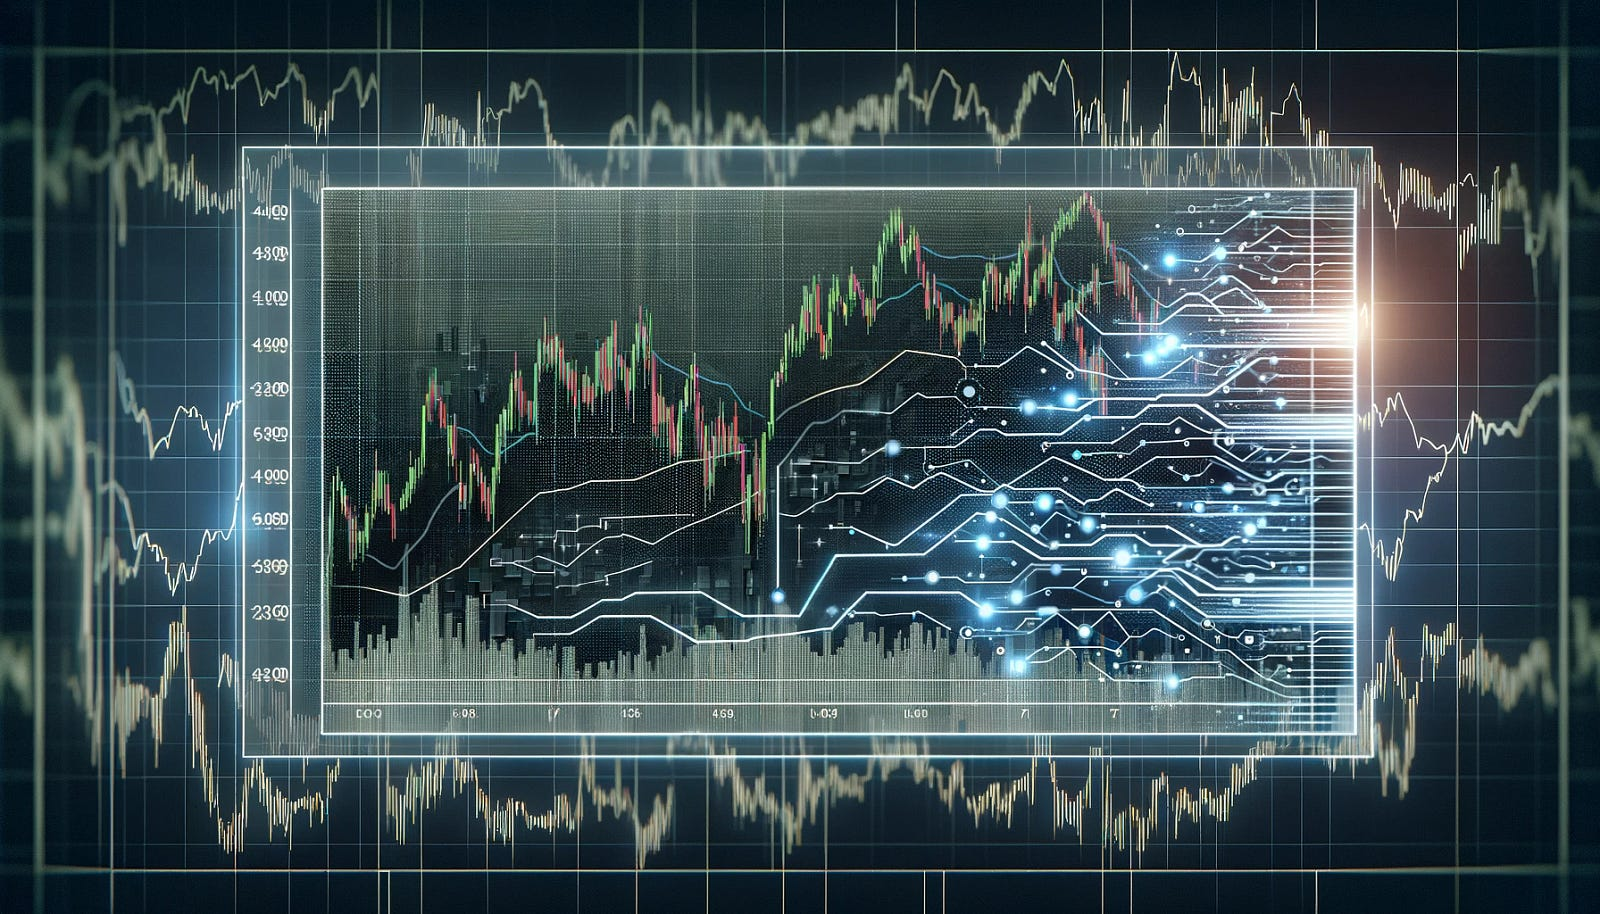

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom classes (built from scratch)
from src.model import WeightInitializer
from src.trainer import PlotManager, EarlyStopping

In [34]:
class BatchNorm:
    def __init__(self, hidden_size):
        self.hidden_size = hidden_size
        self.x = None
        self.gamma = np.ones((hidden_size, 1))
        self.beta = np.zeros((hidden_size, 1))

    def forward(self, x):
        self.x = x
        self.mu = np.mean(x, axis=0)
        self.var = np.var(x, axis=0)
        self.x_norm = (x - self.mu) / np.sqrt(self.var + 1e-8)
        out = self.gamma * self.x_norm + self.beta
        return out

    def backward(self, dout):
        N = dout.shape[0]
        dgamma = np.sum(dout * self.x_norm, axis=0)
        dbeta = np.sum(dout, axis=0)
        dx_norm = dout * self.gamma
        dvar = np.sum(dx_norm * (self.x - self.mu) * -0.5 * (self.var + 1e-8)**-1.5, axis=0)
        dmu = np.sum(dx_norm * -1 / np.sqrt(self.var + 1e-8), axis=0) + dvar * np.mean(-2 * (self.x - self.mu), axis=0)
        dx = dx_norm / np.sqrt(self.var + 1e-8) + dvar * 2 * (self.x - self.mu) / N + dmu / N
        return dx, dgamma, dbeta

class LSTM:
    """
    Long Short-Term Memory (LSTM) network.
    
    Parameters:
    - input_size: int, dimensionality of input space
    - hidden_size: int, number of LSTM units
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method (default: 'xavier')
    """
    def __init__(self, input_size, hidden_size, output_size, init_method='xavier'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_initializer = WeightInitializer(method=init_method)

        # Initialize weights
        self.wf = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wi = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wo = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wc = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))

        # Initialize biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

        # Initialize output layer weights and biases
        self.why = self.weight_initializer.initialize((output_size, hidden_size))
        self.by = np.zeros((output_size, 1))

        # Initialize batch normalization layers
        self.bn_f = BatchNorm(hidden_size)
        self.bn_i = BatchNorm(hidden_size)
        self.bn_o = BatchNorm(hidden_size)
        self.bn_c = BatchNorm(hidden_size)


    @staticmethod
    def sigmoid(z):
        """
        Sigmoid activation function.
        
        Parameters:
        - z: np.ndarray, input to the activation function
        
        Returns:
        - np.ndarray, output of the activation function
        """
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dsigmoid(y):
        """
        Derivative of the sigmoid activation function.

        Parameters:
        - y: np.ndarray, output of the sigmoid activation function

        Returns:
        - np.ndarray, derivative of the sigmoid function
        """
        return y * (1 - y)

    @staticmethod
    def dtanh(y):
        """
        Derivative of the hyperbolic tangent activation function.

        Parameters:
        - y: np.ndarray, output of the hyperbolic tangent activation function

        Returns:
        - np.ndarray, derivative of the hyperbolic tangent function
        """
        return 1 - y * y

    def forward(self, x):
        """
        Forward pass through the LSTM network.

        Parameters:
        - x: np.ndarray, input to the network

        Returns:
        - np.ndarray, output of the network
        - list, caches containing intermediate values for backpropagation
        """
        caches = []
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        h = h_prev
        c = c_prev

        for t in range(x.shape[0]):
            x_t = x[t].reshape(-1, 1)
            combined = np.vstack((h_prev, x_t))
            
            f = self.sigmoid(self.bn_f.forward(np.dot(self.wf, combined) + self.bf))
            i = self.sigmoid(self.bn_i.forward(np.dot(self.wi, combined) + self.bi))
            o = self.sigmoid(self.bn_o.forward(np.dot(self.wo, combined) + self.bo))
            c_ = np.tanh(self.bn_c.forward(np.dot(self.wc, combined) + self.bc))

            
            c = f * c_prev + i * c_
            h = o * np.tanh(c)

            cache = (h_prev, c_prev, f, i, o, c_, x_t, combined, c, h)
            caches.append(cache)

            h_prev, c_prev = h, c

        y = np.dot(self.why, h) + self.by
        return y, caches

    def backward(self, dy, caches, clip_value=1.0):
        """
        Backward pass through the LSTM network.

        Parameters:
        - dy: np.ndarray, gradient of the loss with respect to the output
        - caches: list, caches from the forward pass
        - clip_value: float, value to clip gradients to (default: 1.0)

        Returns:
        - tuple, gradients of the loss with respect to the parameters
        """
        dWf, dWi, dWo, dWc = [np.zeros_like(w) for w in (self.wf, self.wi, self.wo, self.wc)]
        dbf, dbi, dbo, dbc = [np.zeros_like(b) for b in (self.bf, self.bi, self.bo, self.bc)]
        dWhy = np.zeros_like(self.why)
        dby = np.zeros_like(self.by)

        dgamma_f, dbeta_f = np.zeros_like(self.bn_f.gamma), np.zeros_like(self.bn_f.beta)
        dgamma_i, dbeta_i = np.zeros_like(self.bn_i.gamma), np.zeros_like(self.bn_i.beta)
        dgamma_o, dbeta_o = np.zeros_like(self.bn_o.gamma), np.zeros_like(self.bn_o.beta)
        dgamma_c, dbeta_c = np.zeros_like(self.bn_c.gamma), np.zeros_like(self.bn_c.beta)

        dy = dy.reshape(self.output_size, -1)
        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros_like(dh_next)

        for cache in reversed(caches):
            h_prev, c_prev, f, i, o, c_, x_t, combined, c, h = cache

            dh = np.dot(self.why.T, dy) + dh_next
            dc = dc_next + (dh * o * self.dtanh(np.tanh(c)))

            df = dc * c_prev * self.dsigmoid(f)
            di = dc * c_ * self.dsigmoid(i)
            do = dh * self.dtanh(np.tanh(c))
            dc_ = dc * i * self.dtanh(c_)

            df, dgamma_f_, dbeta_f_ = self.bn_f.backward(df)
            di, dgamma_i_, dbeta_i_ = self.bn_i.backward(di)
            do, dgamma_o_, dbeta_o_ = self.bn_o.backward(do)
            dc_, dgamma_c_, dbeta_c_ = self.bn_c.backward(dc_)

            dgamma_f += dgamma_f_
            dbeta_f += dbeta_f_
            dgamma_i += dgamma_i_
            dbeta_i += dbeta_i_
            dgamma_o += dgamma_o_
            dbeta_o += dbeta_o_
            dgamma_c += dgamma_c_
            dbeta_c += dbeta_c_

            dcombined_f = np.dot(self.wf.T, df)
            dcombined_i = np.dot(self.wi.T, di)
            dcombined_o = np.dot(self.wo.T, do)
            dcombined_c = np.dot(self.wc.T, dc_)

            dcombined = dcombined_f + dcombined_i + dcombined_o + dcombined_c
            dh_next = dcombined[:self.hidden_size]
            dc_next = f * dc

            dWf += np.dot(df, combined.T)
            dWi += np.dot(di, combined.T)
            dWo += np.dot(do, combined.T)
            dWc += np.dot(dc_, combined.T)

            dbf += df.sum(axis=1, keepdims=True)
            dbi += di.sum(axis=1, keepdims=True)
            dbo += do.sum(axis=1, keepdims=True)
            dbc += dc_.sum(axis=1, keepdims=True)

        dWhy += np.dot(dy, h.T)
        dby += dy

        gradients = (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby, dgamma_f, dbeta_f, dgamma_i, dbeta_i, dgamma_o, dbeta_o, dgamma_c, dbeta_c)

        for i in range(len(gradients)):
            np.clip(gradients[i], -clip_value, clip_value, out=gradients[i])

        return gradients

    def update_params(self, grads, learning_rate):
        """
        Update the parameters of the network using the gradients.
        """
        dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby, dgamma_f, dbeta_f, dgamma_i, dbeta_i, dgamma_o, dbeta_o, dgamma_c, dbeta_c = grads

        self.wf -= learning_rate * dWf
        self.wi -= learning_rate * dWi
        self.wo -= learning_rate * dWo
        self.wc -= learning_rate * dWc
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby
        self.bn_f.gamma -= learning_rate * dgamma_f
        self.bn_f.beta -= learning_rate * dbeta_f
        self.bn_i.gamma -= learning_rate * dgamma_i
        self.bn_i.beta -= learning_rate * dbeta_i
        self.bn_o.gamma -= learning_rate * dgamma_o
        self.bn_o.beta -= learning_rate * dbeta_o
        self.bn_c.gamma -= learning_rate * dgamma_c
        self.bn_c.beta -= learning_rate * dbeta_c

In [35]:
class LSTMTrainer:
    """
    Trainer for the LSTM network.

    Parameters:
    - model: LSTM, the LSTM network to train
    - learning_rate: float, learning rate for the optimizer
    - patience: int, number of epochs to wait before early stopping
    - verbose: bool, whether to print training information
    - delta: float, minimum change in validation loss to qualify as an improvement
    """
    def __init__(self, model, learning_rate=0.01, patience=7, verbose=True, delta=0):
        self.model = model
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.early_stopping = EarlyStopping(patience, verbose, delta)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=1, clip_value=1.0):
        """
        Train the LSTM network.

        Parameters:
        - X_train: np.ndarray, training data
        - y_train: np.ndarray, training labels
        - X_val: np.ndarray, validation data
        - y_val: np.ndarray, validation labels
        - epochs: int, number of training epochs
        - batch_size: int, size of mini-batches
        - clip_value: float, value to clip gradients to
        """
        for epoch in range(epochs):
            epoch_losses = []
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                losses = []
                
                for x, y_true in zip(batch_X, batch_y):
                    y_pred, caches = self.model.forward(x)
                    loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    losses.append(loss)
                    
                    # Backpropagation to get gradients
                    dy = y_pred - y_true.reshape(-1, 1)
                    grads = self.model.backward(dy, caches, clip_value=clip_value)
                    self.model.update_params(grads, self.learning_rate)

                batch_loss = np.mean(losses)
                epoch_losses.append(batch_loss)

            avg_epoch_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_epoch_loss)

            if X_val is not None and y_val is not None:
                val_loss = self.validate(X_val, y_val)
                self.val_losses.append(val_loss)

                if epoch % 10 == 0:
                    print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}, Val Loss: {val_loss:.5f}')
                
                # Check early stopping condition
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    print("Early stopping")
                    break
            else:
                print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}')


    def compute_loss(self, y_pred, y_true):
        """
        Compute mean squared error loss.
        """
        return np.mean((y_pred - y_true) ** 2)

    def validate(self, X_val, y_val):
        """
        Validate the model on a separate set of data.
        """
        val_losses = []
        for x, y_true in zip(X_val, y_val):
            y_pred, _ = self.model.forward(x)
            loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss)
        return np.mean(val_losses)

In [36]:
class TimeSeriesDataset:
    """
    Dataset class for time series data.

    Parameters:
    - ticker: str, stock ticker symbol
    - start_date: str, start date for data retrieval
    - end_date: str, end date for data retrieval
    - look_back: int, number of previous time steps to include in each sample
    - train_size: float, proportion of data to use for training
    """
    def __init__(self, start_date, end_date, train_size=0.67, look_back=1):
        self.start_date = start_date
        self.end_date = end_date
        self.train_size = train_size
        self.look_back = look_back

    def load_data(self):
        """
        Load stock data.
        
        Returns:
        - np.ndarray, training data
        - np.ndarray, testing data
        """
        df = pd.read_csv('data/google.csv')
        df = df[(df['Date'] >= self.start_date) & (df['Date'] <= self.end_date)]
        df = df.sort_index()
        df = df.loc[self.start_date:self.end_date]
        df = df[['Close']].astype(float)  # Use closing price
        df = self.MinMaxScaler(df.values)  # Convert DataFrame to numpy array
        train_size = int(len(df) * self.train_size)
        train, test = df[0:train_size,:], df[train_size:len(df),:]
        return train, test
    
    def MinMaxScaler(self, data):
        """
        Min-max scaling of the data.
        
        Parameters:
        - data: np.ndarray, input data
        """
        numerator = data - np.min(data, 0)
        denominator = np.max(data, 0) - np.min(data, 0)
        return numerator / (denominator + 1e-7)

    def create_dataset(self, dataset):
        """
        Create the dataset for time series prediction.

        Parameters:
        - dataset: np.ndarray, input data

        Returns:
        - np.ndarray, input data
        - np.ndarray, output data
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-self.look_back):
            a = dataset[i:(i + self.look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + self.look_back, 0])
        return np.array(dataX), np.array(dataY)

    def get_train_test(self):
        """
        Get the training and testing data.

        Returns:
        - np.ndarray, training input
        - np.ndarray, training output
        - np.ndarray, testing input
        - np.ndarray, testing output
        """
        train, test = self.load_data()
        trainX, trainY = self.create_dataset(train)
        testX, testY = self.create_dataset(test)
        return trainX, trainY, testX, testY

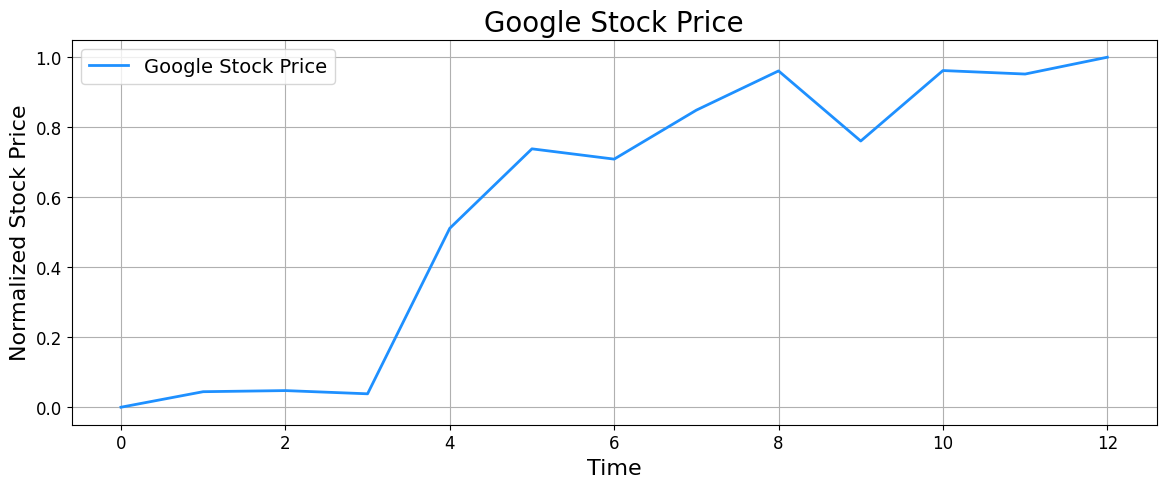

In [37]:
# Instantiate the dataset
dataset = TimeSeriesDataset('2005-01-01', '2020-12-31', train_size=0.7)
trainX, trainY, testX, testY = dataset.get_train_test()

# Plot the data
# Combine train and test data
combined = np.concatenate((trainY, testY))

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(combined, label='Google Stock Price', linewidth=2, color='dodgerblue')
plt.title('Google Stock Price', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Normalized Stock Price', fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [38]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

look_back = 1  # Number of previous time steps to include in each sample
hidden_size = 256  # Number of LSTM units
output_size = 1  # Dimensionality of the output space

lstm = LSTM(input_size=1, hidden_size=hidden_size, output_size=output_size)

# Create and train the LSTM using LSTMTrainer
trainer = LSTMTrainer(lstm, learning_rate=1e-3, patience=50, verbose=True, delta=0.001)
trainer.train(trainX, trainY, testX, testY, epochs=1000, batch_size=32)

Epoch 1/1000 - Loss: 109.35767, Val Loss: 1.78142
Epoch 11/1000 - Loss: 0.50177, Val Loss: 0.05936
Epoch 21/1000 - Loss: 0.30082, Val Loss: 0.04491
Epoch 31/1000 - Loss: 0.16886, Val Loss: 0.02728
Epoch 41/1000 - Loss: 0.11426, Val Loss: 0.01579
Epoch 51/1000 - Loss: 0.08127, Val Loss: 0.01000
Epoch 61/1000 - Loss: 0.07460, Val Loss: 0.00987
Epoch 71/1000 - Loss: 0.06298, Val Loss: 0.01055
Epoch 81/1000 - Loss: 0.05455, Val Loss: 0.01112
Epoch 91/1000 - Loss: 0.04441, Val Loss: 0.01146
Epoch 101/1000 - Loss: 0.14420, Val Loss: 0.01163
Early stopping


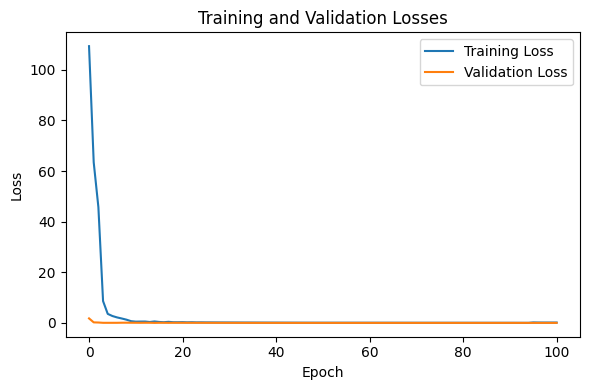

In [39]:
plot_manager = PlotManager()

# Inside your training loop
plot_manager.plot_losses(trainer.train_losses, trainer.val_losses)

# After your training loop
plot_manager.show_plots()